### **Yuang Chen, Siraaj Singh Monga, Ella Ren, Greg Satchell Jr**

In [28]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 8)


## **Predicting the Chances of a Stroke Report**

### **Introduction:**

Strokes, often referred to as brain attacks, occur when blood clots block the blood supply to part of the brain (ischemic stroke). They can also occur when blood vessels in the brain burst (hemorrhagic stroke). It is imperative that strokes are met with immediate treatment to prevent brain damage and death. Strokes remain the second leading cause of death and cause a majority of disabilities worldwide (Katan & Luft, 2018). Here in Canada, strokes have risen to an occurrence rate of 108,707 per year - or roughly one every five minutes (Stroke in Canada is on the rise, 2022).

With this in mind, our research question is the following: How effective are the variables age, bmi, and avg_glucose_level at correctly predicting whether or not an individual is at risk of suffering a stroke? We intend on creating a classification model that will address the predictive research question above.

Stroke Prediction Dataset, the title of the dataset we chose for this project, was adapted from the Kaggle data scientist fedesoriano. The dataset provides ten clinical features/variables for predicting strokes: gender, age, hypertension, heart_disease, ever_married, work_type, residence_type, avg_glucose_level, bmi, and smoking_status. We will only be using three out of the ten variables as we believe these are the most important factors when determining a chance of stroke. The link to the dataset can be found in the references tab.


### **Methods & Results:**

We will first standardize the numerical variables and convert the categorized variables to numerical values so that we can quantify their effect on the prediction result and makes all of the variables contribute equally to the outcome. 

Then we will split the database into two parts: the training set and the testing set by the ratio of 3:1. We also need to make sure that the two parts of the database have approximately the same percentage of different types of variables.

Next, we will split the training set into 5 folds to apply cross-validation to choose the most suitable k-value with the highest accuracy. We will determing the k-value with the highest accuracy by using a visualization. It'll be a geom_point and geom_line graph that plots Neighbors on the x-axis and Accuracy Estimate on the y-axis.

Finally, we will train the model again using the k-value determined and the testing set to evaluate the accuracy by a confusion matrix.
In terms of visualizing the data, we will plot the data on a bar plot where the x-axis is age and the y-axis is whether or not the prediction is correct to measure our result visually. 



In [29]:
#ensures reproducibility
set.seed(1234)

#reading dataset into R
url <- "https://raw.githubusercontent.com/ersq/Group-42-Group-Project/main/healthcare-dataset-stroke-data.csv"
stroke_data <- read_csv(url) |>

#removes N/A values in bmi column
#3832 - 3687 = 145 rows that have missing data in bmi column
filter(bmi != "N/A") |>

#turns bmi column into dbl (previously chr)
mutate(bmi = as.numeric(bmi))

#splits data into training and testing sets
stroke_split <- initial_split(stroke_data, prop = 0.75, strata = stroke) 
    stroke_train <- training(stroke_split)
    stroke_test <- testing(stroke_split)

stroke_train
   


Rows: 5110 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): gender, ever_married, work_type, Residence_type, bmi, smoking_status
dbl (6): id, age, hypertension, heart_disease, avg_glucose_level, stroke

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
22127,Female,18,0,0,No,Private,Urban,82.85,46.9,Unknown,0
14180,Female,13,0,0,No,children,Rural,103.08,18.6,Unknown,0
19723,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
44679,Female,44,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


In [33]:
#ensures reproducibility
set.seed(1234)

# the average glucose level of stroke/no stroke
stroke_train |> 
group_by(stroke) |>
summarize(avg_gluc = mean(avg_glucose_level))

glucose_sd <- sd(stroke_train$avg_glucose_level)
glucose_sd

# the average bmi of stroke/no stroke
stroke_train |> 
group_by(stroke) |>
summarize(avg_BMI = mean(bmi, na.rm = TRUE))

bmi_sd <- sd(stroke_train$bmi)
bmi_sd

# the average age of stroke/no stroke
stroke_train |>
group_by(stroke) |>
summarize(avg_age = mean(age))

age_sd <- sd(stroke_train$age)
age_sd

# the number of people for each smoking status of stroke/no stroke
stroke_train |>
group_by(stroke, smoking_status) |>
summarize(number_of_people = n())
    #will not use smoking_status as a predictor variable; summarized statistics seem to contradict common sense


# the number of people with/without heart disease
stroke_train |>
group_by(stroke, heart_disease) |>
summarize(number_of_people = n())
    #will not use heart_disease as a predictor variable; summarized statistics seem to contradict common sense

stroke,avg_gluc
<dbl>,<dbl>
0,104.0971
1,130.2590


[1] 44.27947

stroke,avg_BMI
<dbl>,<dbl>
0,28.83380
1,30.32349


[1] 7.936146

stroke,avg_age
<dbl>,<dbl>
0,41.89763
1,67.56627


[1] 22.49406

`summarise()` has grouped output by 'stroke'. You can override using the
`.groups` argument.


stroke,smoking_status,number_of_people
<dbl>,<chr>,<int>
0,formerly smoked,570
0,never smoked,1338
0,smokes,527
0,Unknown,1080
1,formerly smoked,46
1,never smoked,65
1,smokes,31
1,Unknown,24


`summarise()` has grouped output by 'stroke'. You can override using the
`.groups` argument.


stroke,heart_disease,number_of_people
<dbl>,<dbl>,<int>
0,0,3362
0,1,153
1,0,136
1,1,30


ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'generalized_bmi' not found

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
6. repr::mime2repr[[mime]](obj)
7. repr_text.default(obj)
8. paste(capture.outp

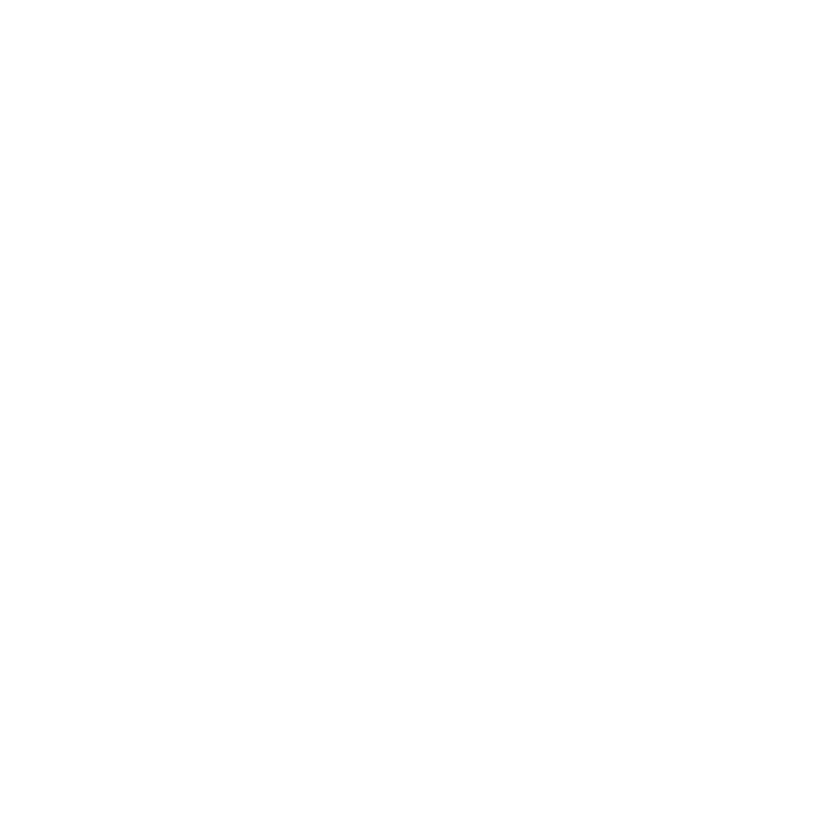

In [37]:
# This bar graph visualizes the relationship between Body Mass Index and whether the person has a stroke or not
bmi_proportion_plot <- stroke_train |>
    ggplot(aes(x = generalized_bmi, fill = stroke_or_not)) +
    geom_histogram(position = 'fill') +
    labs(fill = 'Stroke or Not?', x = 'Body Mass Index', y = 'Proportion') +
    scale_fill_discrete(labels = c('No', 'Yes'))

bmi_proportion_plot

### **Discussion:**

### **References (APA):**



Fedesoriano. (2021, January 26). *Stroke Prediction Dataset*. Kaggle. Retrieved April 6, 2023, from https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download 

Heart and Stroke Foundation of Canada. (2022, December 20). *Stroke in Canada is on the rise*. Heart&Stroke . Retrieved April 6, 2023, from https://www.heartandstroke.ca/what-we-do/media-centre/news-releases/stroke-in-canada-is-on-the-rise#:~:text=A%20new%20study%20funded%20by,as%20well%20as%20better%20prevention. 

Katan, M., & Luft, A. (2018, May 23). *Global Burden of Stroke*. PubMed®. Retrieved April 6, 2023, from https://pubmed.ncbi.nlm.nih.gov/29791947/#:~:text=Stroke%20is%20the%20second%20leading,%2D%20and%20middle%2Dincome%20countries. 


